# H1C IDR3.2 Cross-Power Spectra
Inspect cross-power spectra.

In [1]:
import h5py
import numpy as np
import scipy.stats as stats
import math

from itertools import product

import astropy.units as u

from ipywidgets import interact
import matplotlib.pyplot as plt
import matplotlib.markers
from matplotlib.lines import Line2D

import sys
sys.path.append("/users/pkeller/code/H1C_IDR3.2/")
from closurelib import dspec
from closurelib import plot

## Load Data

### Smooth Errors
The errors have been computed from a very small sample size (n=3). We reduce the uncertainty of the errors by smoothing them along the delay axis with a flat kernel of width 3, effectively increasing the sample size from 3 to 9. 

In [2]:
trclasses = ["EQ14", "EQ28"]
fields = ["A", "B", "C", "D", "E"]
pols = ["XX", "YY"]

data = dict()


for trclass in trclasses:
    data.update({trclass: dict()})
    
    for field in fields:
        path = f"/lustre/aoc/projects/hera/pkeller/data/H1C_IDR3.2/sample/{trclass}_F{field}_B2_XPS_2.h5"
        data[trclass].update({field: dict()})
        
        # load data
        with h5py.File(path, "r") as f:
            data[trclass][field].update({"XPS AVG": f["XPS AVG"][()]})
            data[trclass][field].update({"ERR AVG": np.sqrt(np.convolve(f["ERR AVG"][()]**2, np.ones(3), 'same') / 3)})
            data[trclass][field].update({"Noise AVG": f["Noise AVG"][()]})
            
            delay = f["delay"][()]
            idx = np.where(delay >= 0)[0]
            
            k = dspec.get_k_parallel(delay * u.s, freq=164.28 * u.MHz).to(u.Mpc**-1).value
            k_perp_14 = dspec.get_k_perpendicular(14.6 * u.m, 164.28 * u.MHz).to(u.Mpc ** -1).value
            k_perp_28 = dspec.get_k_perpendicular(29.2 * u.m, 164.28 * u.MHz).to(u.Mpc ** -1).value
            
            if field == "EQ14":
                k = np.sqrt(k**2 + k_perp_14**2)
            else:
                k = np.sqrt(k**2 + k_perp_28**2)
            
            if field in ["A", "B", "C"]:
                data[trclass][field].update({"XPS AVG model": f["XPS AVG model"][()]})
                data[trclass][field].update({"ERR AVG model": f["ERR AVG model"][()]})
                data[trclass][field].update({"Noise AVG model": f["Noise AVG model"][()]})

                np.savetxt(f"cross_power_spectrum_{trclass}_field_{field}.txt",
                           ((k - np.flip(k))[idx] / 2,
                            (delay - np.flip(delay))[idx] / 2 * 1e6,
                            (data[trclass][field]["XPS AVG model"].real + np.flip(data[trclass][field]["XPS AVG model"].real))[idx] / 2, 
                            (data[trclass][field]["XPS AVG model"].imag + np.flip(data[trclass][field]["XPS AVG model"].imag))[idx] / 2, 
                            np.sqrt((data[trclass][field]["ERR AVG model"].real**2 + np.flip(data[trclass][field]["ERR AVG model"].real, axis=-1)**2) / 4)[idx],
                            ), header="kappa [psuedo h/Mpc], delay [mus], 2/3*Re{P(kappa)} [pseudo mK^2/h^3*Mpc^3], 2/3*Im{P(kappa)} [pseudo mK^2/h^3*Mpc^3], 2 sigma error [pseudo mK^2/h^3*Mpc^3]")       

            np.savetxt(f"cross_power_spectrum_{trclass}_field_{field}.txt",
                       ((k - np.flip(k))[idx] / 2,
                        (delay - np.flip(delay))[idx] / 2 * 1e6,
                        (data[trclass][field]["XPS AVG"].real + np.flip(data[trclass][field]["XPS AVG"].real))[idx] / 2, 
                        (data[trclass][field]["XPS AVG"].imag + np.flip(data[trclass][field]["XPS AVG"].imag))[idx] / 2, 
                        np.sqrt((data[trclass][field]["ERR AVG"].real**2 + np.flip(data[trclass][field]["ERR AVG"].real, axis=-1)**2) / 4)[idx],
                        ), header="kappa [psuedo h/Mpc], delay [mus], 2/3*Re{P(kappa)} [pseudo mK^2/h^3*Mpc^3], 2/3*Im{P(kappa)} [pseudo mK^2/h^3*Mpc^3], 2 sigma error [pseudo mK^2/h^3*Mpc^3]")       

k = dspec.get_k_parallel(delay * u.s, freq=164.28 * u.MHz).to(u.Mpc**-1).value
k_perp_14 = dspec.get_k_perpendicular(14.6 * u.m, 164.28 * u.MHz).to(u.Mpc ** -1).value
k_perp_28 = dspec.get_k_perpendicular(29.2 * u.m, 164.28 * u.MHz).to(u.Mpc ** -1).value

## Plot

### Overview

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


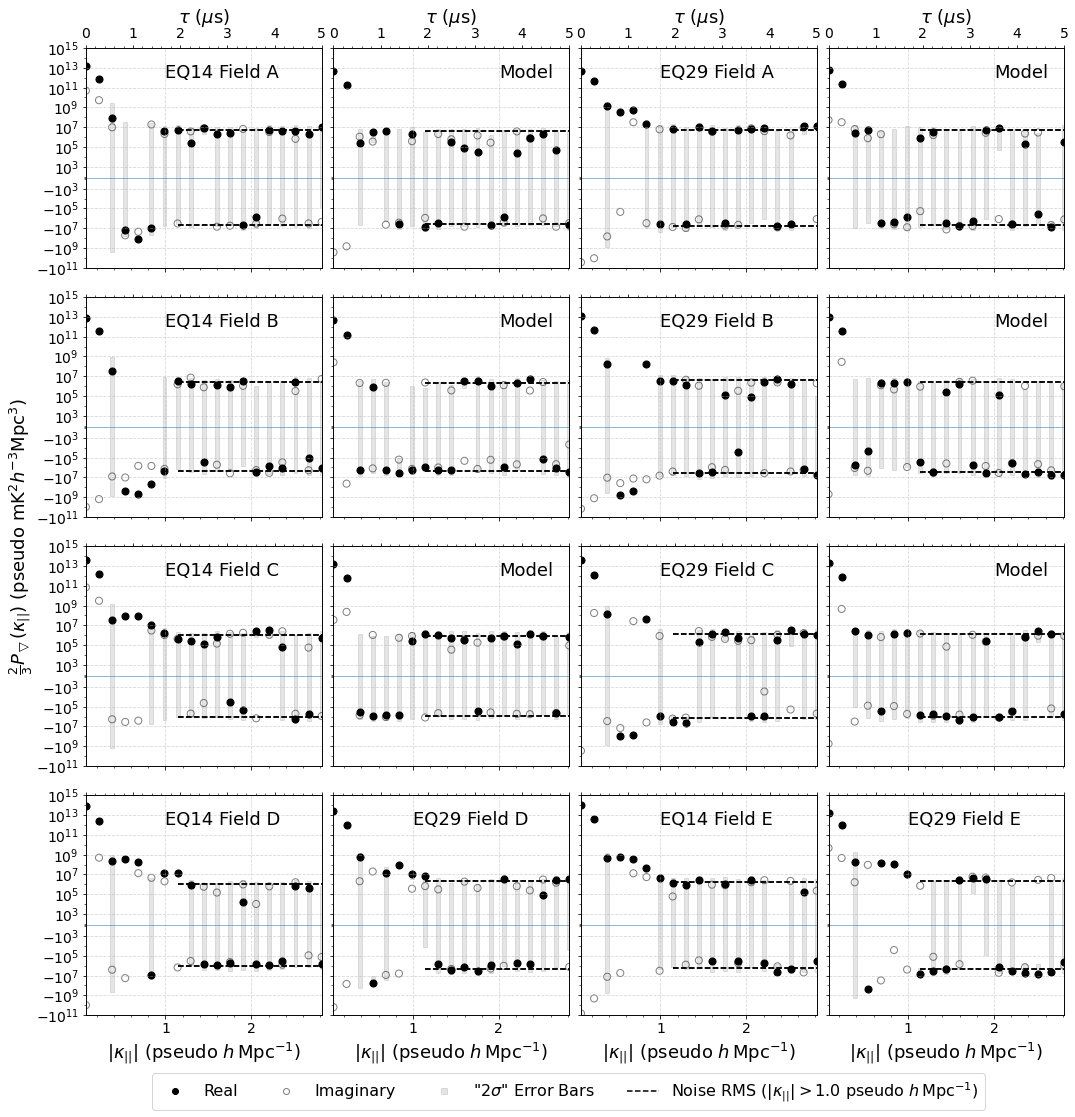

In [3]:
import imp; imp.reload(plot); imp.reload(dspec)
fig, ax = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)
yticks =  np.hstack([-1 * 10 ** np.arange(3, 12, 2), 10 ** np.arange(3, 16, 2)])
fields = ["A", "B", "C", "D", "E"]


for i, field in enumerate(fields):
    if field in ["A", "B", "C"]:
        ax[i, 0], rms1 = plot.xps_plot(data["EQ14"][field]["XPS AVG"], data["EQ14"][field]["ERR AVG"], freq=164.28 * u.MHz, onesided=True, ax=ax[i, 0], linthresh=1e3, tau_ax=(i==0), nsig=2)
        ax[i, 2], rms2 = plot.xps_plot(data["EQ28"][field]["XPS AVG"], data["EQ28"][field]["ERR AVG"], freq=164.28 * u.MHz, onesided=True, ax=ax[i, 2], linthresh=1e3, tau_ax=(i==0), nsig=2)        
        ax[i, 1], rms3 = plot.xps_plot(data["EQ14"][field]["XPS AVG model"], data["EQ14"][field]["ERR AVG model"], freq=164.28 * u.MHz, onesided=True, ax=ax[i, 1], linthresh=1e3, tau_ax=(i==0), nsig=2)
        ax[i, 3], rms4 = plot.xps_plot(data["EQ28"][field]["XPS AVG model"], data["EQ28"][field]["ERR AVG model"], freq=164.28 * u.MHz, onesided=True, ax=ax[i, 3], linthresh=1e3, tau_ax=(i==0), nsig=2)
        ax[i, 0].text(1, 1e12, f"EQ14 Field {field}", fontsize=18)
        ax[i, 2].text(1, 1e12, f"EQ29 Field {field}", fontsize=18)
        ax[i, 1].text(2, 1e12, "Model", fontsize=18)
        ax[i, 3].text(2, 1e12, "Model", fontsize=18)
        
    elif field == "D":
        ax[i, 0], rms1 = plot.xps_plot(data["EQ14"][field]["XPS AVG"], data["EQ14"][field]["ERR AVG"], freq=164.28 * u.MHz, onesided=True, ax=ax[i, 0], linthresh=1e3, tau_ax=(i==0), nsig=2)
        ax[i, 1], rms2 = plot.xps_plot(data["EQ28"][field]["XPS AVG"], data["EQ28"][field]["ERR AVG"], freq=164.28 * u.MHz, onesided=True, ax=ax[i, 1], linthresh=1e3, tau_ax=(i==0), nsig=2)
        ax[i, 0].text(1, 1e12, f"EQ14 Field {field}", fontsize=18)
        ax[i, 1].text(1, 1e12, f"EQ29 Field {field}", fontsize=18)
    
    elif field == "E":
        ax[i-1, 2], rms1 = plot.xps_plot(data["EQ14"][field]["XPS AVG"], data["EQ14"][field]["ERR AVG"], freq=164.28 * u.MHz, onesided=True, ax=ax[i-1, 2], linthresh=1e3, tau_ax=(i==0), nsig=2)
        ax[i-1, 3], rms2 = plot.xps_plot(data["EQ28"][field]["XPS AVG"], data["EQ28"][field]["ERR AVG"], freq=164.28 * u.MHz, onesided=True, ax=ax[i-1, 3], linthresh=1e3, tau_ax=(i==0), nsig=2)
        ax[i-1, 2].text(1, 1e12, f"EQ14 Field {field}", fontsize=18)
        ax[i-1, 3].text(1, 1e12, f"EQ29 Field {field}", fontsize=18)
        
ax[-1, 0].set_xlabel(r"$|\kappa_{||}|$ (pseudo $h\,\mathrm{Mpc}^{-1}$)", fontsize=18)
ax[-1, 1].set_xlabel(r"$|\kappa_{||}|$ (pseudo $h\,\mathrm{Mpc}^{-1}$)", fontsize=18)
ax[-1, 2].set_xlabel(r"$|\kappa_{||}|$ (pseudo $h\,\mathrm{Mpc}^{-1}$)", fontsize=18)
ax[-1, 3].set_xlabel(r"$|\kappa_{||}|$ (pseudo $h\,\mathrm{Mpc}^{-1}$)", fontsize=18)

custom_markers = [Line2D([], [], color='k', marker='o', linestyle="None"),
                 Line2D([], [], mfc='None', mec='grey', marker='o', linestyle="None"),
                 Line2D([], [], mfc='k', mec='k', marker='s', alpha=0.1, linestyle="None"),
                 Line2D([0], [0], color="k", linestyle="dashed")]

plt.setp(ax, ylim=[-10**8, 10**15], yticks=yticks);
plt.tight_layout()
fig.subplots_adjust(wspace=0.05)
fig.subplots_adjust(left=0.08)
fig.text(0.02, 0.5, r"$\frac{2}{3}P_\bigtriangledown\left(\kappa_{||}\right)$ (pseudo $\mathrm{mK}^2h^{-3}\mathrm{Mpc}^3$)", fontsize=18, rotation=90., va="center", ha="center");
plt.legend(custom_markers, ['Real', 'Imaginary', '"2$\sigma$" Error Bars', 'Noise RMS ($|\kappa_{||}|>1.0$ pseudo $h\,\mathrm{Mpc}^{-1}$)'], bbox_to_anchor=(0.92, 0.01), bbox_transform=fig.transFigure, ncol=4, fontsize=16)
plt.savefig("/users/pkeller/code/H1C_IDR3.2/plots/xps.pdf", bbox_inches='tight')

### Paper Plots

4775642.252919988 3648932.254067544 0.7640715239581576
2342739.471278572 2194005.5883258963 0.936512836883436
1006011.3203713855 895376.7327575596 0.8900264983370333


/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


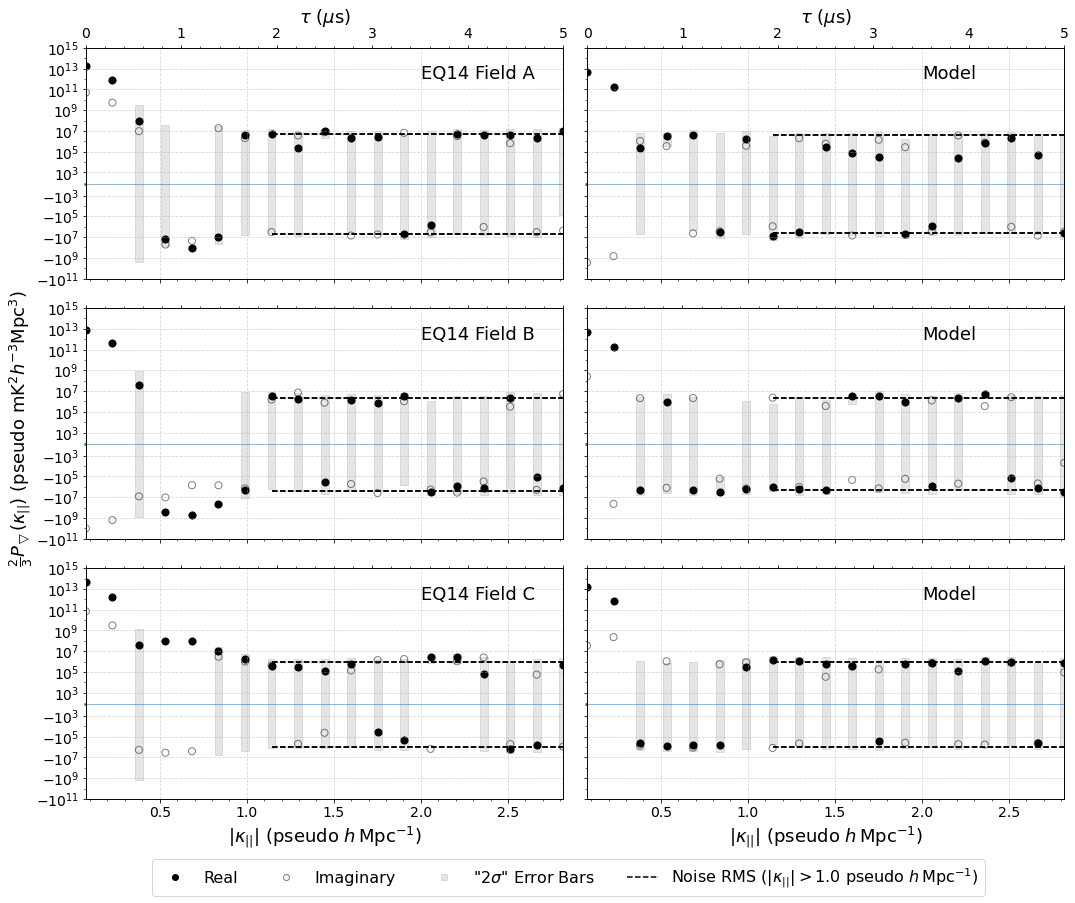

In [4]:
import imp; imp.reload(plot); imp.reload(dspec)
fig, ax = plt.subplots(3, 2, figsize=(15, 12), sharex=True, sharey=True)
yticks =  np.hstack([-1 * 10 ** np.arange(3, 12, 2), 10 ** np.arange(3, 16, 2)])
fields = ["A", "B", "C"]


for i, field in enumerate(fields):
    ax[i, 0], rms1 = plot.xps_plot(data["EQ14"][field]["XPS AVG"], data["EQ14"][field]["ERR AVG"], freq=164.28 * u.MHz, onesided=True, ax=ax[i, 0], linthresh=1e3, tau_ax=(i==0), nsig=2)
    ax[i, 1], rms2 = plot.xps_plot(data["EQ14"][field]["XPS AVG model"], data["EQ14"][field]["ERR AVG model"], freq=164.28 * u.MHz, onesided=True, ax=ax[i, 1], linthresh=1e3, tau_ax=(i==0), nsig=2)
    
    #_, rms2 = plot.xps_plot(data["EQ28"][field]["XPS AVG"], data["EQ28"][field]["ERR AVG"], freq=164.28 * u.MHz, onesided=True, ax=ax[i, 0], linthresh=1e3, tau_ax=(i==0), nsig=2)

    ax[i, 0].text(2, 1e12, f"EQ14 Field {field}", fontsize=18)
    ax[i, 1].text(2, 1e12, "Model", fontsize=18)
    print(np.mean(rms1), np.mean(rms2), np.mean(rms2) / np.mean(rms1))
        
        
ax[-1, 0].set_xlabel(r"$|\kappa_{||}|$ (pseudo $h\,\mathrm{Mpc}^{-1}$)", fontsize=18)
ax[-1, 1].set_xlabel(r"$|\kappa_{||}|$ (pseudo $h\,\mathrm{Mpc}^{-1}$)", fontsize=18)


custom_markers = [Line2D([], [], color='k', marker='o', linestyle="None"),
                 Line2D([], [], mfc='None', mec='grey', marker='o', linestyle="None"),
                 Line2D([], [], mfc='k', mec='k', marker='s', alpha=0.1, linestyle="None"),
                 Line2D([0], [0], color="k", linestyle="dashed")]

plt.setp(ax, ylim=[-10**8, 10**15], yticks=yticks);
plt.tight_layout()
fig.subplots_adjust(wspace=0.05)
fig.subplots_adjust(left=0.08)
fig.text(0.02, 0.5, r"$\frac{2}{3}P_\bigtriangledown\left(\kappa_{||}\right)$ (pseudo $\mathrm{mK}^2h^{-3}\mathrm{Mpc}^3$)", fontsize=18, rotation=90., va="center", ha="center");
plt.legend(custom_markers, ['Real', 'Imaginary', '"2$\sigma$" Error Bars', 'Noise RMS ($|\kappa_{||}|>1.0$ pseudo $h\,\mathrm{Mpc}^{-1}$)'], bbox_to_anchor=(0.92, 0.01), bbox_transform=fig.transFigure, ncol=4, fontsize=16)
plt.savefig("/users/pkeller/code/H1C_IDR3.2/plots/xps_eq14.pdf", bbox_inches='tight')

5674948.844055465 4632873.880279607 1.2249305702474607
3731688.439883055 2915817.615827558 1.2798085928374978
1439892.5365665797 1211288.7069413848 1.1887277808462695


/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


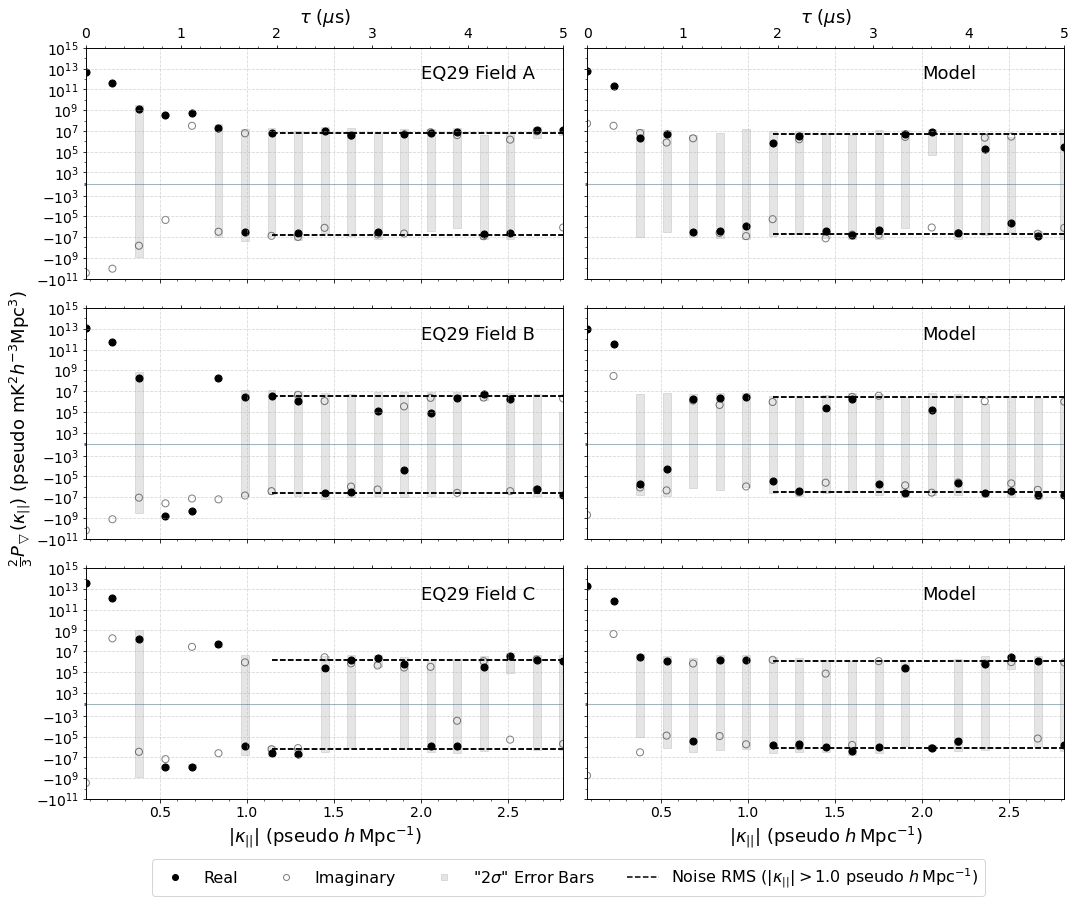

In [5]:
import imp; imp.reload(plot); imp.reload(dspec)
fig, ax = plt.subplots(3, 2, figsize=(15, 12), sharex=True, sharey=True)
yticks =  np.hstack([-1 * 10 ** np.arange(3, 12, 2), 10 ** np.arange(3, 16, 2)])
fields = ["A", "B", "C"]


for i, field in enumerate(fields):
    ax[i, 0], rms1 = plot.xps_plot(data["EQ28"][field]["XPS AVG"], data["EQ28"][field]["ERR AVG"], freq=164.28 * u.MHz, onesided=True, ax=ax[i, 0], linthresh=1e3, tau_ax=(i==0), nsig=2)
    ax[i, 1], rms2 = plot.xps_plot(data["EQ28"][field]["XPS AVG model"], data["EQ28"][field]["ERR AVG model"], freq=164.28 * u.MHz, onesided=True, ax=ax[i, 1], linthresh=1e3, tau_ax=(i==0), nsig=2)
    ax[i, 0].text(2, 1e12, f"EQ29 Field {field}", fontsize=18)
    ax[i, 1].text(2, 1e12, "Model", fontsize=18)
    print(np.mean(rms1), np.mean(rms2), np.mean(rms1) / np.mean(rms2))
        
ax[-1, 0].set_xlabel(r"$|\kappa_{||}|$ (pseudo $h\,\mathrm{Mpc}^{-1}$)", fontsize=18)
ax[-1, 1].set_xlabel(r"$|\kappa_{||}|$ (pseudo $h\,\mathrm{Mpc}^{-1}$)", fontsize=18)


custom_markers = [Line2D([], [], color='k', marker='o', linestyle="None"),
                 Line2D([], [], mfc='None', mec='grey', marker='o', linestyle="None"),
                 Line2D([], [], mfc='k', mec='k', marker='s', alpha=0.1, linestyle="None"),
                 Line2D([0], [0], color="k", linestyle="dashed")]

plt.setp(ax, ylim=[-10**8, 10**15], yticks=yticks);
plt.tight_layout()
fig.subplots_adjust(wspace=0.05)
fig.subplots_adjust(left=0.08)
fig.text(0.02, 0.5, r"$\frac{2}{3}P_\bigtriangledown\left(\kappa_{||}\right)$ (pseudo $\mathrm{mK}^2h^{-3}\mathrm{Mpc}^3$)", fontsize=18, rotation=90., va="center", ha="center");
plt.legend(custom_markers, ['Real', 'Imaginary', '"2$\sigma$" Error Bars', 'Noise RMS ($|\kappa_{||}|>1.0$ pseudo $h\,\mathrm{Mpc}^{-1}$)'], bbox_to_anchor=(0.92, 0.01), bbox_transform=fig.transFigure, ncol=4, fontsize=16)
plt.savefig("/users/pkeller/code/H1C_IDR3.2/plots/xps_eq28.pdf", bbox_inches='tight')

1055572.001534393 2191767.721927437 2.076379175216333
1921447.776409044 2427468.357354458 1.2633538039171202


/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


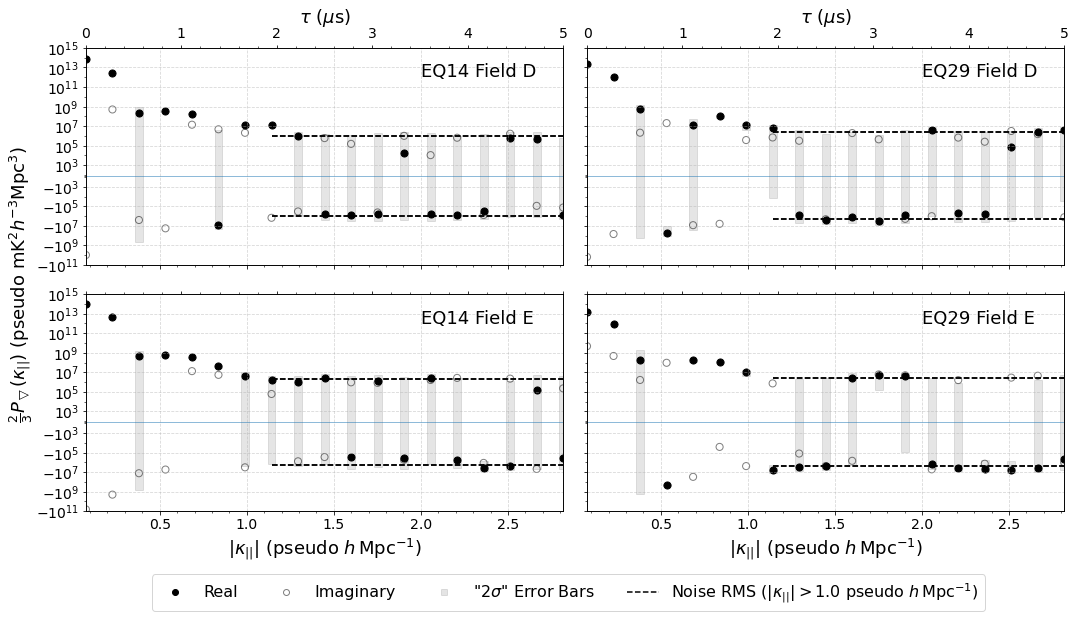

In [6]:
import imp; imp.reload(plot); imp.reload(dspec)
fig, ax = plt.subplots(2, 2, figsize=(15, 8), sharex=True, sharey=True)
yticks =  np.hstack([-1 * 10 ** np.arange(3, 12, 2), 10 ** np.arange(3, 16, 2)])
fields = ["D", "E"]


for i, field in enumerate(fields):
    ax[i, 0], rms1 = plot.xps_plot(data["EQ14"][field]["XPS AVG"], data["EQ14"][field]["ERR AVG"], freq=164.28 * u.MHz, onesided=True, ax=ax[i, 0], linthresh=1e3, tau_ax=(i==0), nsig=2)
    ax[i, 1], rms2 = plot.xps_plot(data["EQ28"][field]["XPS AVG"], data["EQ28"][field]["ERR AVG"], freq=164.28 * u.MHz, onesided=True, ax=ax[i, 1], linthresh=1e3, tau_ax=(i==0), nsig=2)
    ax[i, 0].text(2, 1e12, f"EQ14 Field {field}", fontsize=18)
    ax[i, 1].text(2, 1e12, f"EQ29 Field {field}", fontsize=18)
    
    print(np.mean(rms1), np.mean(rms2), np.mean(rms2) / np.mean(rms1))
        
ax[-1, 0].set_xlabel(r"$|\kappa_{||}|$ (pseudo $h\,\mathrm{Mpc}^{-1}$)", fontsize=18)
ax[-1, 1].set_xlabel(r"$|\kappa_{||}|$ (pseudo $h\,\mathrm{Mpc}^{-1}$)", fontsize=18)


custom_markers = [Line2D([], [], color='k', marker='o', linestyle="None"),
                 Line2D([], [], mfc='None', mec='grey', marker='o', linestyle="None"),
                 Line2D([], [], mfc='k', mec='k', marker='s', alpha=0.1, linestyle="None"),
                 Line2D([0], [0], color="k", linestyle="dashed")]

plt.setp(ax, ylim=[-10**8, 10**15], yticks=yticks);
plt.tight_layout()
fig.subplots_adjust(wspace=0.05)
fig.subplots_adjust(left=0.08)
fig.text(0.02, 0.5, r"$\frac{2}{3}P_\bigtriangledown\left(\kappa_{||}\right)$ (pseudo $\mathrm{mK}^2h^{-3}\mathrm{Mpc}^3$)", fontsize=18, rotation=90., va="center", ha="center");
plt.legend(custom_markers, ['Real', 'Imaginary', '"2$\sigma$" Error Bars', 'Noise RMS ($|\kappa_{||}|>1.0$ pseudo $h\,\mathrm{Mpc}^{-1}$)'], bbox_to_anchor=(0.92, 0.01), bbox_transform=fig.transFigure, ncol=4, fontsize=16)
plt.savefig("/users/pkeller/code/H1C_IDR3.2/plots/xps_DE.pdf", bbox_inches='tight')

## Triangle Plot

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


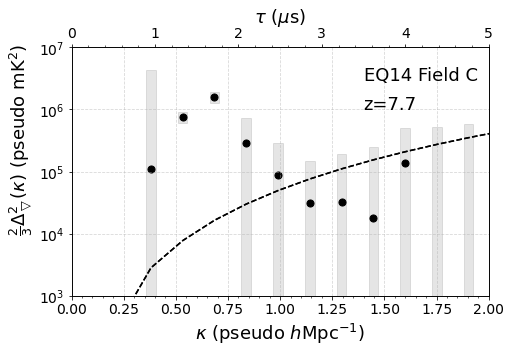

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
yticks =  10 ** np.arange(3, 8, 1)

xps = data["EQ14"]["C"]["XPS AVG"]
err = data["EQ14"]["C"]["ERR AVG"]

ax, rms = plot.xps_plot(xps, err, freq=164.28 * u.MHz, onesided=True, ax=ax, linthresh=1e3, tau_ax=(i//2==0), cosmo=True, bls=14.6 * u.m, nsig=2)

ax.set_xlabel(r"$\kappa$ (pseudo $h\mathrm{Mpc}^{-1}$)", fontsize=18)
ax.set_ylim([1e3, 10**7])

plt.setp(ax, xlim=[0.0, 2.0], ylim=[1e3, 10**7], yticks=yticks);
plt.tight_layout()

fig.subplots_adjust(wspace=0.05)
fig.subplots_adjust(left=0.12)
fig.text(0.02, 0.6, r"$\frac{2}{3}\Delta^2_\bigtriangledown\left(\kappa\right)$ (pseudo $\mathrm{mK}^2$)", fontsize=18, rotation=90., va="center", ha="center");
ax.text(1.4, 3*1e6, f"EQ14 Field C", fontsize=18)
ax.text(1.4, 1*1e6, f"z=7.7", fontsize=18)
plt.savefig("/users/pkeller/code/H1C_IDR3.2/plots/triangle_plot_EQ14_FC.pdf", bbox_inches='tight')
plt.savefig("/users/pkeller/code/H1C_IDR3.2/plots/triangle_plot_EQ14_FC.png", bbox_inches='tight')

## Print Upper Limits

In [8]:
from scipy.special import erf, erfinv

xps = data["EQ14"]["C"]["XPS AVG"]
err = data["EQ14"]["C"]["ERR AVG"]

kappa_14 = np.sqrt(k**2 + k_perp_14**2)
kappa_28 = np.sqrt(k**2 + k_perp_28**2)

N = len(kappa_14) // 2

kappa_14 = 0.5 * (np.abs(kappa_14) + np.flip(np.abs(kappa_14)))[N:]
kappa_28 = 0.5 * (np.abs(kappa_28) + np.flip(np.abs(kappa_28)))[N:]

xps = 0.5 * (xps + np.flip(xps))[N:]
err = np.sqrt(0.25 * (err**2 + np.flip(err)**2))[N:]

table = []

for i, (bp, sig) in enumerate(zip(xps.real, err)):
    bp *= kappa_14[i]**3 / (2 * np.pi**2)
    sig *= kappa_14[i]**3 / (2 * np.pi**2)
    E = erf(bp / sig / np.sqrt(2))
    ul = sig * np.sqrt(2) * (erfinv(1 - (1 + E) * 0.045500263896) + bp / sig / np.sqrt(2))
    print("{:.2f} & ({:.0f})$^2$ & ({:.0f})$^2$\\\\".format(kappa_14[i], ul**0.5, sig**0.5))
    
    table.append((kappa_14[i], ul**0.5, sig**0.5))

np.savetxt(f"upper_limits_EQ14_field_C.txt", np.asarray(table).T, header="kappa [pseudo h/Mpc], 2/3*Delta^2 [pseudo mK^2], Standard Deviation [pseudo mK^2]")


0.08 & (33163)$^2$ & (534)$^2$\\
0.23 & (31296)$^2$ & (2157)$^2$\\
0.38 & (2058)$^2$ & (1443)$^2$\\
0.53 & (937)$^2$ & (274)$^2$\\
0.69 & (1367)$^2$ & (401)$^2$\\
0.84 & (824)$^2$ & (473)$^2$\\
0.99 & (518)$^2$ & (317)$^2$\\
1.14 & (372)$^2$ & (241)$^2$\\
1.29 & (431)$^2$ & (285)$^2$\\
1.45 & (491)$^2$ & (338)$^2$\\
1.60 & (679)$^2$ & (424)$^2$\\
1.75 & (720)$^2$ & (512)$^2$\\
1.90 & (783)$^2$ & (573)$^2$\\
2.06 & (1403)$^2$ & (672)$^2$\\
2.21 & (1648)$^2$ & (794)$^2$\\
2.36 & (1289)$^2$ & (904)$^2$\\
2.51 & (1172)$^2$ & (1015)$^2$\\
2.66 & (1373)$^2$ & (1055)$^2$\\
2.82 & (1631)$^2$ & (1061)$^2$\\


## Plot Cumulative Distribution Functions
The cumulative distribution functions of the cross-power spectra at delays > 2us is expected to be noise dominated. Comparing the cumulative distribution functions of the real and imaginary parts of the data and noise power spectra respectrively allows to asses if there are any noise biases of excess variance in the data.

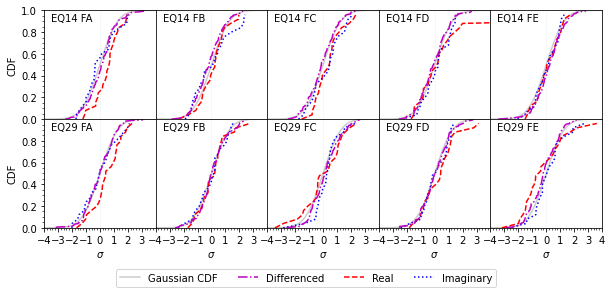

In [9]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))

fields = ["A", "B", "C", "D", "E"]

for i, (trclass, field) in enumerate(product(trclasses, fields)):
    idx = np.where(np.abs(k) > 1)[0]
    d = data[trclass][field][f"XPS AVG"][..., idx]
    dr = np.sort(d.real)
    di = np.sort(d.imag)
    
    n = data[trclass][field][f"Noise AVG"][idx].reshape(-1)
    n = np.hstack([n.real, n.imag])
    n = np.sort(n)
    sig = np.std(n)
    
    if trclass == "EQ28":
        trclass = "EQ29"

    xrange = np.linspace(-4, 4, 1000)
    cdf_gauss = [0.5*(1 + math.erf(xrange[i]/np.sqrt(2))) for i in range(1000)]

    ax[i//5, i%5].vlines(0.0, 0, 1.0, linewidth=0.5, alpha=0.1)
    ax[i//5, i%5].plot(xrange, cdf_gauss, color="k", alpha=0.2)
    ax[i//5, i%5].plot(dr / sig, np.arange(len(dr)) / (len(dr)), color="r", linestyle="--")
    ax[i//5, i%5].plot(di / sig, np.arange(len(di)) / (len(di)), color="b", linestyle=":")
    ax[i//5, i%5].plot(n / sig, np.arange(len(n)) / (len(n)), color="m", linestyle="-.")
    ax[i//5, i%5].text(-3.5, 0.9, f"{trclass} F{field}")
    ax[i//5, i%5].minorticks_on()    

fig.subplots_adjust(wspace=0.0, hspace=0.0)

custom_lines = [Line2D([0], [0], color="k", alpha=0.2),
                Line2D([0], [0], color="m", linestyle="-."),
                Line2D([0], [0], color="r", linestyle="--"),
                Line2D([0], [0], color="b", linestyle=":")]

plt.legend(custom_lines, ['Gaussian CDF', 'Differenced', 'Real', 'Imaginary'], bbox_to_anchor=(0.76, 0.0), bbox_transform=fig.transFigure, ncol=4)
plt.setp(ax, xlim=[-4, 4], ylim=[0, 1], xticks=[], yticks=[]);
plt.setp(ax[:, 0], yticks=np.arange(0.0, 1.0, 0.2));
plt.setp(ax[0, 0], yticks=np.arange(0.0, 1.2, 0.2));
plt.setp(ax[-1], xticks=np.arange(-4, 4));
plt.setp(ax[-1, -1], xticks=np.arange(-4, 5));
plt.setp(ax[:, 0], ylabel="CDF");
plt.setp(ax[-1], xlabel=r"$\sigma$");

plt.savefig("/users/pkeller/code/H1C_IDR3.2/plots/cdf.pdf", bbox_inches='tight')

## Statistical Tests
We use two statistical tests to our data: (1) Shapiro-Wilk test for normality and (2) Kolmogorov-Smirnov test. The first test draws on the observation that the noise is well matched to a Gaussian distribution. The second test is to see if how well the distribution of the power spectra at high delays matches the noise distribution. The K-S test is nonparametric and therefore makes no assumptions about the distributions of the data and the noise. To be exact, we are testing the Null-Hypothesis that the two distributions under comparison are equal. We reject the Null-Hypothesis based on a chosen significance threshold of 0.05. A p-value p<0.023 means we reject the null-hypothesis whereas p>0.023 means we can't reject the null-hypothesis. A p-value of 0.023 roughly corresponds to a 2 sigma rejection level in the case of a Gaussian distriubution.

In [10]:
fields = ["A", "B", "C", "D", "E"]
for i, (trclass, field) in enumerate(product(trclasses, fields)):
    idx = np.where(np.abs(k) > 1)[0]
    d = data[trclass][field][f"XPS AVG"][..., idx]
    n = data[trclass][field][f"Noise AVG"][idx].reshape(-1)
    n = np.hstack([n.real, n.imag])
    shapiro = stats.shapiro(n / n.std())
    ad_real = stats.anderson_ksamp([d.real, n])
    ad_imag = stats.anderson_ksamp([d.imag, n])
    
    color1, color2, color3, color4 = "", "", "", ""
    
    
    if shapiro[1]<0.01:
        color1 = "\cellcolor{mymagenta}"
    else:
        color1 = "\cellcolor{myyellow}"
    
    if ad_real[0]>ad_real[1][2]:
        color2 = "\cellcolor{mymagenta}"
    else:
        color2 = "\cellcolor{myyellow}"
        
    if ad_imag[0]>ad_imag[1][2]:
        color3 = "\cellcolor{mymagenta}"
    else:
        color3 = "\cellcolor{myyellow}"     
    
    # print LaTex table
    if field in ["A", "B", "C"]:
        dm = data[trclass][field][f"XPS AVG model"][..., idx]
        ad_model = stats.anderson_ksamp([d.real, dm.real])
        
        if ad_model[0]>ad_model[1][2]:
            color4 = "\cellcolor{mymagenta}"
        else:
            color4 = "\cellcolor{myyellow}"

        print("{} Field {} & {} {:.3f} & {} {:.3f} & {} {} & {} {:.3f} & {} {} & {} {:.3f} & {} {} & {} {:.3f} & {} {}\\\\".format(trclass, field, color1, shapiro[0], color1, shapiro[1], color1, shapiro[1]<0.05, color2, ad_real[0], color2, ad_real[0]>ad_real[1][2], color3, ad_imag[0], color3, ad_imag[0]>ad_imag[1][2], color4, ad_model[0], color4, ad_model[0]>ad_model[1][2]))
    else:    
        print("{} Field {} & {} {:.3f} & {} {:.3f} & {} {} & {} {:.3f} & {} {} & {} {:.3f} & {} {} & {} {} & {} {}\\\\".format(trclass, field, color1, shapiro[0], color1, shapiro[1], color1, shapiro[1]<0.05, color2, ad_real[0], color2, ad_real[0]>ad_real[1][2], color3, ad_imag[0], color3, ad_imag[0]>ad_imag[1][2], "", "-", "", "-"))

    #print("{} Field {} & {} {:.3f} & {} {:.3f} & {} {:.3f} & {} {:.3f} \\\\".format(trclass, field, color1, shapiro[0], color1, shapiro[1], color2, ad_real[0], color3, ad_imag[0]))
    

EQ14 Field A & \cellcolor{myyellow} 0.992 & \cellcolor{myyellow} 0.605 & \cellcolor{myyellow} False & \cellcolor{myyellow} 1.889 & \cellcolor{myyellow} False & \cellcolor{myyellow} -0.043 & \cellcolor{myyellow} False & \cellcolor{mymagenta} 4.877 & \cellcolor{mymagenta} True\\
EQ14 Field B & \cellcolor{myyellow} 0.994 & \cellcolor{myyellow} 0.762 & \cellcolor{myyellow} False & \cellcolor{myyellow} -0.062 & \cellcolor{myyellow} False & \cellcolor{myyellow} 0.425 & \cellcolor{myyellow} False & \cellcolor{myyellow} -0.976 & \cellcolor{myyellow} False\\
EQ14 Field C & \cellcolor{myyellow} 0.994 & \cellcolor{myyellow} 0.842 & \cellcolor{myyellow} False & \cellcolor{myyellow} 0.971 & \cellcolor{myyellow} False & \cellcolor{myyellow} 0.560 & \cellcolor{myyellow} False & \cellcolor{myyellow} 0.140 & \cellcolor{myyellow} False\\
EQ14 Field D & \cellcolor{myyellow} 0.993 & \cellcolor{myyellow} 0.627 & \cellcolor{myyellow} False & \cellcolor{myyellow} -0.051 & \cellcolor{myyellow} False & \cellco

/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: p-value capped: true value larger than 0.25
  if __name__ == '__main__':
/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: p-value capped: true value larger than 0.25
  
/lustre/aoc/projects/hera/pkeller/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: p-value capped: true value larger than 0.25
